<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-and-Simulation-in-Python" data-toc-modified-id="Modeling-and-Simulation-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling and Simulation in Python</a></span><ul class="toc-item"><li><span><a href="#Code-from-previous-notebooks" data-toc-modified-id="Code-from-previous-notebooks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Code from previous notebooks</a></span><ul class="toc-item"><li><span><a href="#Using-root_bisect" data-toc-modified-id="Using-root_bisect-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Using <code>root_bisect</code></a></span></li><li><span><a href="#Mixing-liquids" data-toc-modified-id="Mixing-liquids-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Mixing liquids</a></span></li></ul></li><li><span><a href="#Mixing-immediately" data-toc-modified-id="Mixing-immediately-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Mixing immediately</a></span></li><li><span><a href="#Mixing-at-the-end" data-toc-modified-id="Mixing-at-the-end-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Mixing at the end</a></span><ul class="toc-item"><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Analysis</a></span></li></ul></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Exercises</a></span></li></ul></li></ul></div>

# Modeling and Simulation in Python

Chapter 16

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [20]:
def test_func(x):
    return x**2-4

fsolve(test_func,x0=10)


array([2.])

In [10]:
fsolve?

## Code from previous notebooks

In [55]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

In [56]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [57]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

In [61]:
coffee

,values
init,T 90 dtype: int64
r,1
volume,300
temp,90
t_0,0
t_end,30
dt,1
T_env,22


In [62]:
update_func(coffee.init,0,coffee)

,values
T,22.0


### Using `root_bisect`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [26]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `root_bisect`, which searches for a root by bisection.  The first argument is the function whose roots we want.  The second argument is an interval that contains a root.

In [65]:
test = fsolve(func,1)
test

array([1.])

The result is an object that contains the root that was found and other information.

In [7]:
res.root

If we provide a different interval, we find a different root.

In [64]:
res = root_bisect(func, [1.5, 2.5])

,values
converged,True
root,2


In [9]:
res.root

If the interval doesn't contain a root, the results explain the error.

In [63]:
res = root_bisect(func, [4, 5])

,values
converged,False
flag,4.000000 and 5.000000 do not bracket a root


We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [54]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r=r, volume=300, t_end=30)
    results = run_simulation(system, update_func)
    T_final = get_last_value(results.T)
    return T_final - 70

In [33]:
error_func1(0.01)

2.2996253904030937

In [78]:
linspace(0,20,5)

array([ 0.,  5., 10., 15., 20.])

In [77]:
solution = pd.Series([])

for tem in linspace(0,20,5):
    solution[tem] = fsolve(error_func1,tem)

solution

0     [0.011543084583978368]
7       [1.9884569154355232]
14      [1.9884569154228684]
21       [1.988456915621176]
28      [1.9884569154368896]
35      [1.9884569154185836]
42       [1.988456915417763]
49      [1.9884569154160656]
56      [1.9884569157399479]
63       [1.988456916200355]
70      [1.9884569154256946]
dtype: object

With `r=0.01`, we end up a little too warm.

In [75]:
error_func1(r=0.01)

2.2996253904030937

With `r=0.02`, we end up too cold.

In [76]:
error_func1(r=0.02)

-10.907066281994297

In [67]:
res = fsolve(error_func1,0)

array([0.01154308])

In [69]:
r_coffee = res[0]

0.011543084583978368

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [79]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final = get_last_value(results.T)

69.99999999999997

In [74]:
results

,T
0,90
1,89.2151
2,88.4392
3,87.6723
4,86.9142
5,86.1649
6,85.4243
7,84.6921
8,83.9685
9,83.2532


**Exercise:**  When you call `root_bisect`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `root_bisect` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `root_bisect`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

In [99]:
r_milk = 0.14
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=15)
results = run_simulation(milk, update_func)
T_final = get_last_value(results.T)

20.23019389031005

In [96]:
def error_func_milk(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    """
    milk = make_system(T_init=5, r=r, volume=50, t_end=15)
    results = run_simulation(milk, update_func)
    T_final = get_last_value(results.T)
    return T_final - 20

In [97]:
fsolve(error_func_milk,0.02)

array([0.13296079])

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [100]:
def mix(system1, system2):
    """Simulates the mixture of two liquids.
    
    system1: System representing coffee
    system2: System representing milk
    
    returns: System representing the mixture
    """
    assert system1.t_end == system2.t_end
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.temp, system2.temp
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       r=system1.r,
                       volume=V_mix,
                       t_end=30)

`mix` requires the `System` objects to have `temp` as a system variable.  `make_system` initializes this variable;
the following function makes sure it gets updated when we run a simulation.

In [101]:
def run_and_set(system):
    """Run a simulation and set the final temperature.
    
    system: System
    
    returns: TimeFrame
    """
    results = run_simulation(system, update_func)
    system.temp = get_last_value(results.T)
    return results

## Mixing immediately

Next here's what we get if we add the milk immediately.

In [102]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
coffee.temp

90

In [103]:
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=30)
milk.temp

5

In [104]:
mix_first = mix(coffee, milk)
mix_first.temp

77.85714285714286

In [105]:
mix_results = run_and_set(mix_first)
mix_first.temp

61.428571428571395

## Mixing at the end

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [30]:
coffee_results = run_and_set(coffee)
coffee.temp

In [31]:
milk_results = run_and_set(milk)
milk.temp

Here's what the results look like.

In [32]:
plot(coffee_results.T, label='coffee')
plot(milk_results.T, '--', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('figs/chap16-fig01.pdf')

Here's what happens when we mix them.

In [33]:
mix_last = mix(coffee, milk)
mix_last.temp

In [34]:
mix_last.temp - mix_first.temp

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [106]:
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=t_add)
    coffee_results = run_and_set(coffee)
    
    milk = make_system(T_init=5, r=r_milk, volume=50, t_end=t_add)
    milk_results = run_and_set(milk)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_and_set(mixture)

    return mixture.temp

We can try it out with a few values.

In [107]:
run_and_mix(t_add=0, t_total=30)

61.428571428571395

In [108]:
run_and_mix(t_add=15, t_total=30)

62.93043792160082

In [109]:
run_and_mix(t_add=30, t_total=30)

63.116536019614294

And then sweep a range of values for `t_add`

In [110]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the result looks like.

Saving figure to file figs/chap16-fig02.pdf


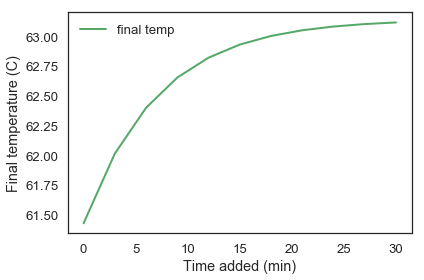

In [111]:
plot(sweep, label='final temp', color='C2')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)')

savefig('figs/chap16-fig02.pdf')

### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [41]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
        
    system: System object
    
    returns: TimeFrame
    """
    T_env, r = system.T_env, system.r
    
    T_init = system.init.T    
    ts = linspace(0, system.t_end)
    
    T_array = T_env + (T_init - T_env) * exp(-r * ts)
    
    # to be consistent with run_simulation,
    # we put the array into a TimeFrame
    return TimeFrame(T_array, index=ts, columns=['T'])

Here's how we run it.  From the analysis (see `chap16sympy.ipynb`), we have the computed value of `r_coffee2`

In [42]:
r_coffee2 = 0.011610223142273859
coffee2 = make_system(T_init=90, r=r_coffee2, volume=300, t_end=30)

In [43]:
results = run_analysis(coffee2)
T_final_analysis = get_last_value(results.T)

And we can compare to the results from simulation.

In [44]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final_simulation = get_last_value(results.T)

They are identical except for a small roundoff error.

In [45]:
T_final_analysis - T_final_simulation

## Exercises

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [46]:
# Solution goes here